# Sieci konwolucyjne

Zadanie dla Państwa na te ćwiczenia to implementacja funkcji konwolucji oraz max pooling dla obrazów.

In [158]:
# ploting
# Max Pooling Test
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
# imports
import torch

%matplotlib inline

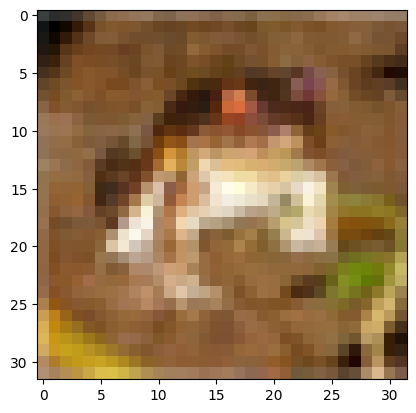

In [159]:
# data loading
cifar_sample = np.load("resources/cifar_sample.npy")
# get a first random image
np_image = cifar_sample[0]
# this should plot a blurry frog
plt.imshow(np_image.transpose(1, 2, 0))

### Wzory na rozmiary
**Pytanie 1**: Jaki będzie rozmiar obrazka na wyjściu konwolucji/poolingu przy parametrach poniżej.  
**Uwaga**: zarówno we wzorach jak i w kodzie używana jest torchowa konwencja *channel first*.

Stride: $ \hspace{95px} S $  
Padding: $ \hspace{80px} P $  
Obrazek wejściowy: $ \hspace{12px} C_i \times H_i \times W_i$  
Filtry: $ \hspace{100px} K \times C_f \times F \times F $  

Gdzie: $C_i$ to liczba kanału obrazu wejściowego, $H_i, W_i$ to odpowiednio wysokość i szerokość obrazu wejściowego. $K$ to liczba filtrów, $C_f$ liczba kanałów w każdym filtrze, $F$ to zarówno wysokość jak i szerokość filtra (rozważamy tylko filtry kwadratowe).

Obrazek wyjściowy: $ \hspace{15px} C_o \times H_o \times W_o $  


$ \hspace{140px} C_o = K $

$ \hspace{140px} H_o = \lfloor \frac{H_i + 2P - F}{S} \rfloor + 1 $

$ \hspace{140px} W_o = \lfloor \frac{W_i + 2P - F}{S} \rfloor + 1 $

**Pytanie 2**: Ile wag (floatów) ma taka warstwa konwolucyja?

 $ \text{Liczba wag} = K \times C_f \times F \times F + K $


### Wizualna pomoc do konwolucji
[Źródło](http://cs231n.github.io/convolutional-networks/)

<img src="resources/cnn.gif"></img>

### Zadanie 1:  Konwolucja (5 pkt.)
Zadaniem jest zaimplementowanie funkcji konwolucji i poolingu dla obrazka 2D. Implementacja nie musi być optymalna pod względem złożoności czasowej (tzn. można/zaleca się używać pętli). 

Warunkiem zaliczenia zadania jest przejście komórek testowych dla konwolucji i poolingu. W razie problemów polecam zacząć od poolingu, który jest podobny do konwolucji, ale mniej skomplikowany.

In [160]:
def convolution(image: torch.tensor, 
                filters: torch.tensor, 
                bias: torch.tensor, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param filters: torch.Tensor 
        Filters to use in convolution of shape (K, C, F, F)
    :param bias: torch.Tensor 
        Bias vector of shape (K,)
    :param stride: int
        Stride to use in convolution
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    padded_image = torch.nn.functional.pad(image, (padding,) * 4)
    img_channels, img_height, img_width = padded_image.shape
    n_filters, filter_channels, filter_size, filter_size = filters.shape 
    # calculate the dimensions of the output image
    out_height = (img_height - filter_size) // stride + 1
    out_width = (img_width - filter_size) // stride + 1
    out_channels = n_filters
    
    # your code here
    res = torch.empty(out_channels, out_height, out_width)

    for i in range(out_height):
        for j in range(out_width):
            x_coord = i * stride
            y_coord = j * stride
            frag = padded_image[:, x_coord:x_coord+filter_size, y_coord:y_coord+filter_size]
            res[:, i, j] = (frag[torch.newaxis, ...] * filters).sum(dim=(1, 2, 3)) + bias

    return res

In [161]:
# Convolution Test

# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
paddings = [0, 1, 2, 3]
strides = [1, 2, 3, 4]
filters = [
    (torch.randn((2, 3, 3, 3)), torch.randn((2))),
    (torch.randn((2, 3, 5, 5)), torch.randn((2))),
    (torch.randn((5, 3, 1, 1)), torch.randn((5))),
]

# test all combinations
for (filt, bias), stride, padding in product(filters, strides, paddings):
    # your convolution
    out = convolution(image, filt, bias, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.conv2d(
        input=image.unsqueeze(0), weight=filt, bias=bias, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

### Zadanie 2. Max Pooling (2 pkt.)
Operacja *max pooling* jest analogiczna do zwykłej konwolucji, lecz zamiast operacji mnożenia z zadanym filtrem na każdym fragmencie wejścia wykonywana jest funkcja *max*.

In [162]:
def max_pooling(image: torch.tensor, 
                kernel_size: int, 
                stride: int = 1, 
                padding: int = 1):
    """
    :param image: torch.Tensor 
        Input image of shape (C, H, W)
    :param kernel_size: int 
        Size of the square pooling kernel
    :param stride: int
        Stride to use in pooling
    :param padding: int
       Zero-padding to add on all sides of the image 
    """
    # get image dimensions
    padded_image = torch.nn.functional.pad(image, (padding,) * 4)
    img_channels, img_height, img_width = padded_image.shape
    # calculate the dimensions of the output image
    out_height = (img_height - kernel_size) // stride + 1
    out_width = (img_width - kernel_size) // stride + 1
    out_channels = img_channels

    # your code here
    res = torch.empty(out_channels, out_height, out_width)

    for i in range(out_height):
        for j in range(out_width):
            x_coord = i * stride
            y_coord = j * stride
            frag = padded_image[:, x_coord:x_coord+kernel_size, y_coord:y_coord+kernel_size]
            res[:, i, j] = torch.flatten(frag, start_dim=1).max(dim=1)[0]

    return res

In [163]:
# cast the frog to tensor
image = torch.tensor(np_image)
# preapre parameters for testing
kernel_sizes = [2, 3, 4]
paddings = [0, 1]
strides = [1, 2, 3, 4]

# test all combinations
for kernel_size, stride, padding in product(kernel_sizes, strides, paddings):
    # your pooling
    out = max_pooling(image, kernel_size=kernel_size, stride=stride, padding=padding)
    # PyTorch equivalent
    out_torch = torch.nn.functional.max_pool2d(
        input=image.unsqueeze(0), kernel_size=kernel_size, padding=padding, stride=stride
    )
    # asserts
    assert out_torch.squeeze().shape == out.shape
    assert torch.allclose(out, out_torch.squeeze(), atol=1e-5, rtol=1e-5)

# Trenowanie sieci kowolucyjnych

**Uwaga:** Poniższa część notebooka jest stworzona z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [164]:
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip, ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


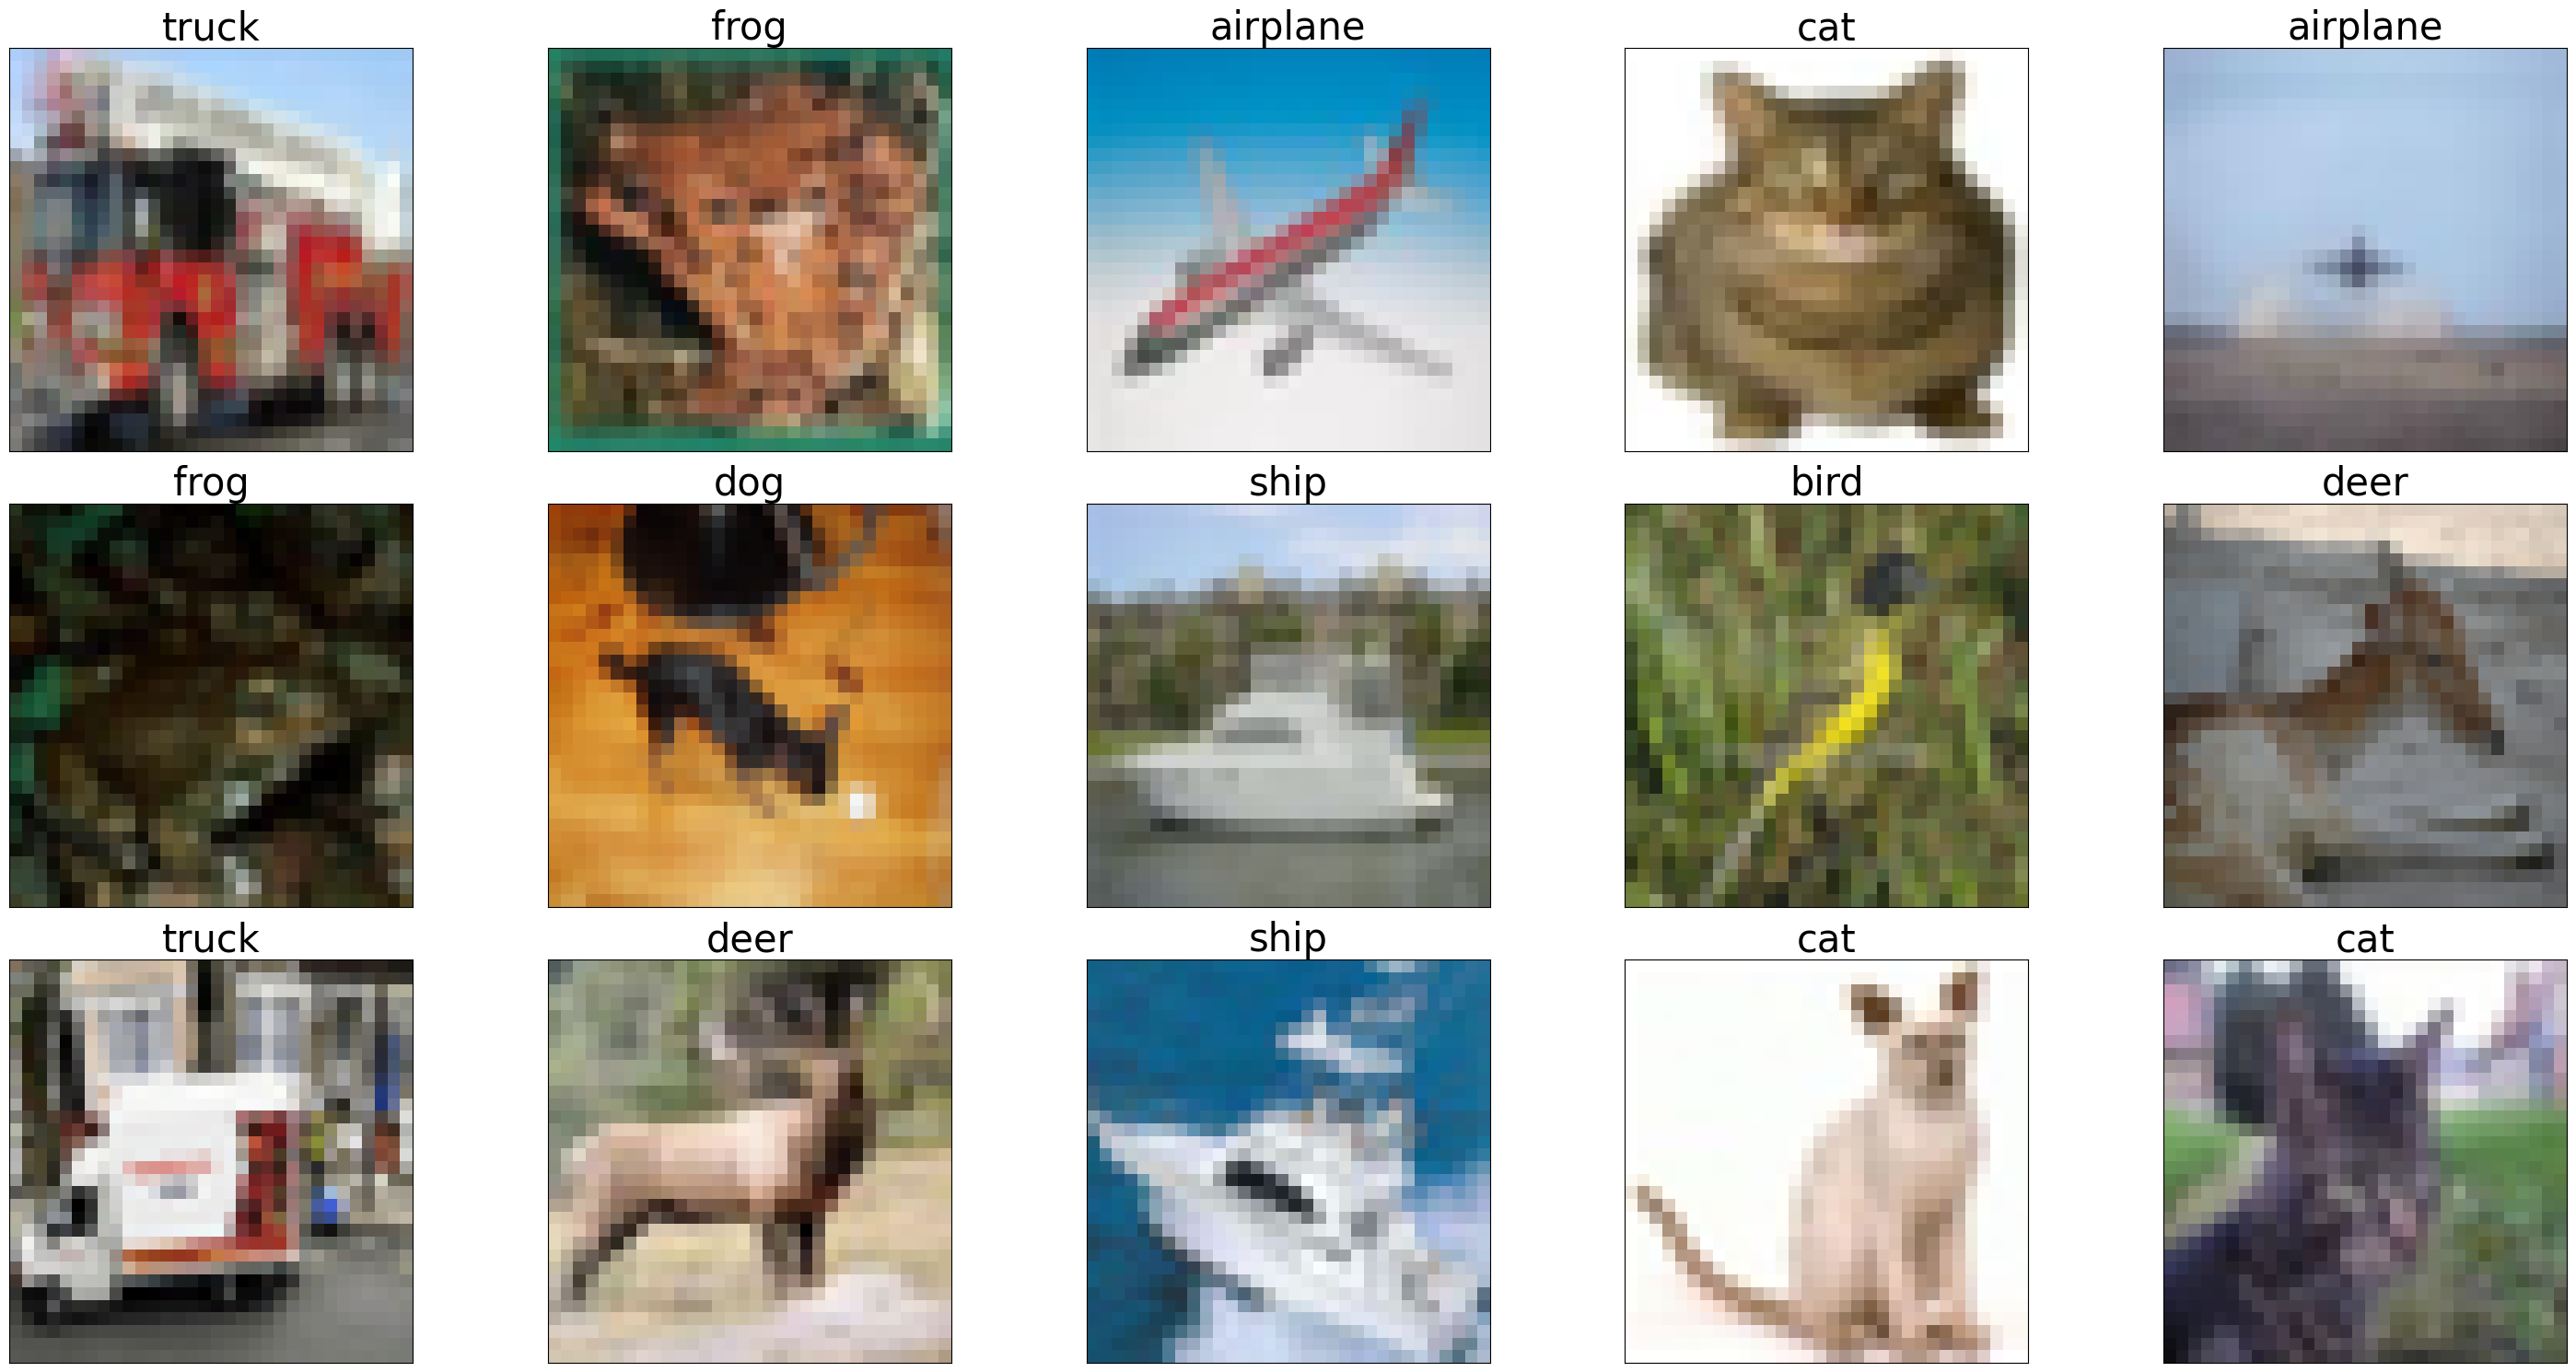

In [165]:
dataset = CIFAR10(root="./data", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 3. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [166]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module
from torch import nn
from torch.optim import Optimizer, SGD
from torchvision.transforms import transforms

conv_net = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(32, 64, 5),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(64 * 5 * 5, 240),
    nn.ReLU(),
    nn.Linear(240, 120),
    nn.ReLU(),
    nn.Linear(120, 10)
)

In [167]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data',
                        train=True,
                        download=True,
                        transform=transform)

test_dataset = CIFAR10(root='./data',
                       train=False,
                       download=True,
                       transform=transform)


train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [168]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami

def train(model: nn.Module, train_loader: DataLoader, optimiser: Optimizer, criterion: nn.Module, device: str):
    total_loss = 0.0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimiser.zero_grad()
        y = model(inputs)
        loss = criterion(y, labels)
        loss.backward()
        optimiser.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)


def test(model: nn.Module, test_loader: DataLoader, criterion: nn.Module, device: str):
    correct = 0
    total = 0
    total_loss = 0.0
    model.eval()

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        y = model(images)
        loss = criterion(y, labels)
        _, pred = torch.max(y.data, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()

    return correct / total, total_loss / len(test_loader)

In [169]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using '{device}' device")

model = conv_net.to(device)

epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.001)

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_acc, test_loss = test(model, test_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Test Accuracy: {test_acc}, Test Loss: {test_loss}")

Using 'mps' device
Epoch 1/20, Train Loss: 1.707558795401454, Test Accuracy: 0.5205, Test Loss: 1.3361345529556274
Epoch 2/20, Train Loss: 1.281921880953014, Test Accuracy: 0.6063, Test Loss: 1.1255816221237183
Epoch 3/20, Train Loss: 1.131520042128861, Test Accuracy: 0.6366, Test Loss: 1.0355552434921265
Epoch 4/20, Train Loss: 1.0351427886553108, Test Accuracy: 0.6499, Test Loss: 0.999287337064743
Epoch 5/20, Train Loss: 0.9611089317128062, Test Accuracy: 0.6747, Test Loss: 0.9381991326808929
Epoch 6/20, Train Loss: 0.9005430249363184, Test Accuracy: 0.6907, Test Loss: 0.8884182274341583
Epoch 7/20, Train Loss: 0.847874240501225, Test Accuracy: 0.6877, Test Loss: 0.907356858253479
Epoch 8/20, Train Loss: 0.7971654425686225, Test Accuracy: 0.7137, Test Loss: 0.8375829458236694
Epoch 9/20, Train Loss: 0.7564612453766167, Test Accuracy: 0.7278, Test Loss: 0.7967720925807953
Epoch 10/20, Train Loss: 0.7096730136191473, Test Accuracy: 0.7159, Test Loss: 0.8190069794654846
Epoch 11/20, Tra

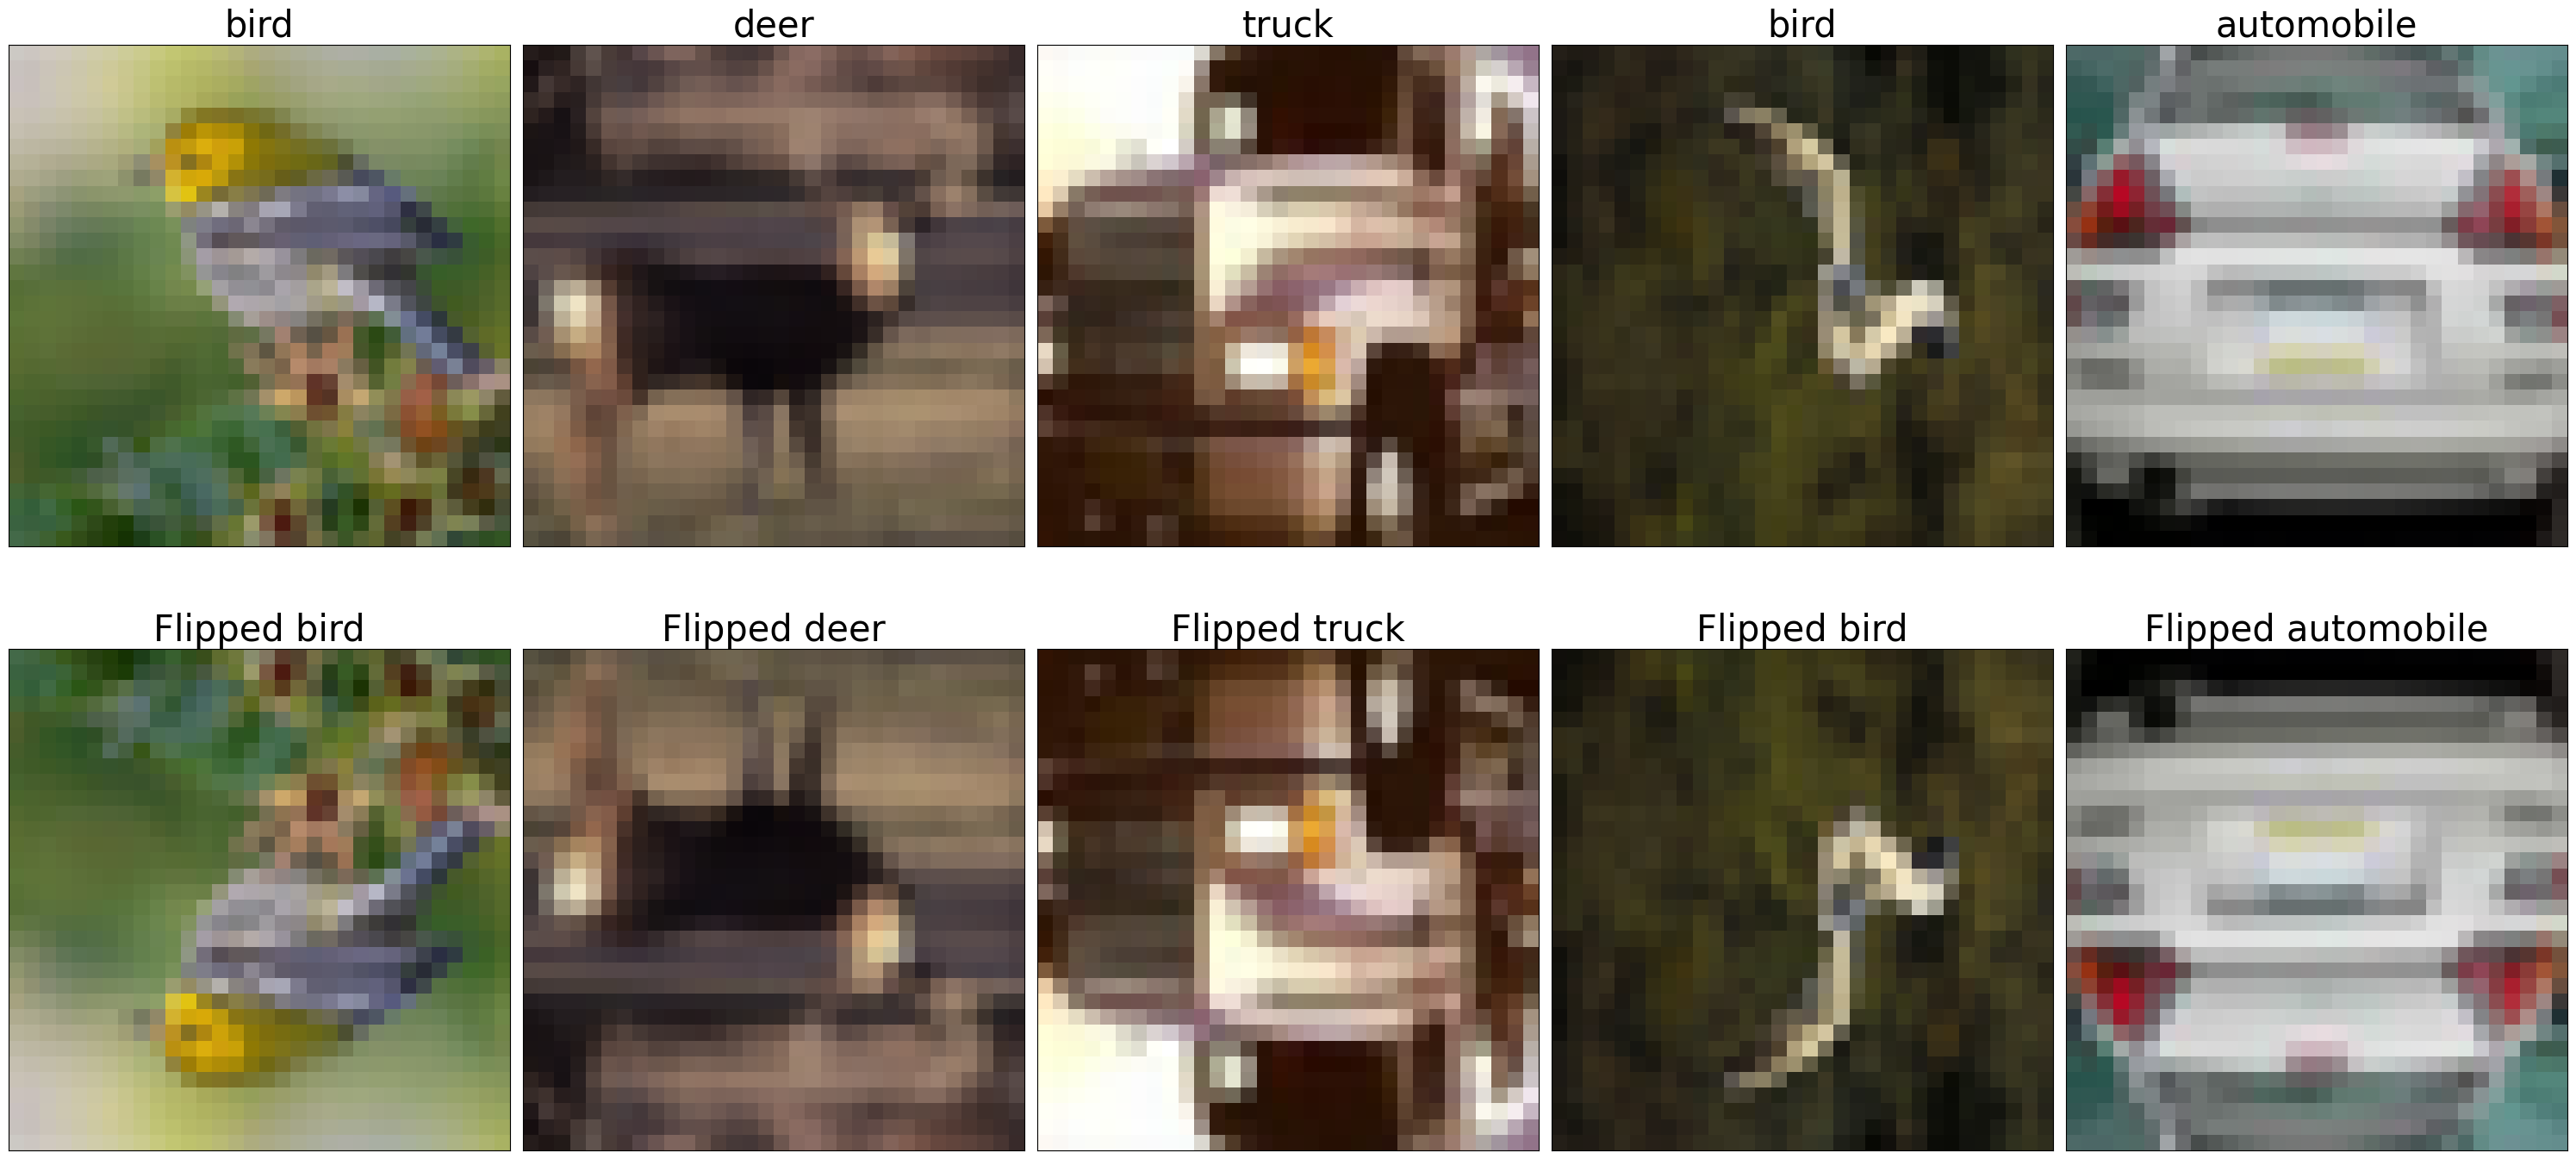

In [170]:
# load test set
dataset = CIFAR10(root="./data", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 4. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [171]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe

second_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data',
                        train=True,
                        download=True,
                        transform=second_transform)

test_dataset = CIFAR10(root='./data',
                       train=False,
                       download=True,
                       transform=transform)


train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [172]:
model2 = conv_net.to(device)
epochs = 20

for epoch in range(epochs):
    train_loss = train(model2, train_loader, optimizer, criterion, device)
    test_acc, test_loss = test(model2, test_loader, criterion, device)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Test Accuracy: {test_acc}, Test Loss: {test_loss}")

Epoch 1/20, Train Loss: 1.1376634068746119, Test Accuracy: 0.7378, Test Loss: 0.7555875778198242
Epoch 2/20, Train Loss: 1.0278755969323219, Test Accuracy: 0.7438, Test Loss: 0.7521259784698486
Epoch 3/20, Train Loss: 0.9811144103968515, Test Accuracy: 0.748, Test Loss: 0.729608952999115
Epoch 4/20, Train Loss: 0.9451154330734164, Test Accuracy: 0.753, Test Loss: 0.7090225219726562
Epoch 5/20, Train Loss: 0.9237683975799009, Test Accuracy: 0.7541, Test Loss: 0.7028208374977112
Epoch 6/20, Train Loss: 0.9037583324783016, Test Accuracy: 0.7706, Test Loss: 0.6711727678775787
Epoch 7/20, Train Loss: 0.8861802436387166, Test Accuracy: 0.7694, Test Loss: 0.6700528264045715
Epoch 8/20, Train Loss: 0.871621617898997, Test Accuracy: 0.7697, Test Loss: 0.6626902222633362
Epoch 9/20, Train Loss: 0.8589478037995286, Test Accuracy: 0.7706, Test Loss: 0.6732403039932251
Epoch 10/20, Train Loss: 0.8461311887053773, Test Accuracy: 0.7684, Test Loss: 0.673077791929245
Epoch 11/20, Train Loss: 0.8284083